# LDA - Sentences - Iterative filtering - Run 0 

Note: 

This notebook loads the models from f1000_LDA_Sentence_Run_0 and returns "f1000_tokenized_LDA_sentence_1.tsv", which is the input for "f1000_LDA_Sentence_Run" with ITER = 1.

## Configuration

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import re
from collections import defaultdict  # For word frequency
from operator import itemgetter
from tqdm import tqdm_notebook as tqdm
import IPython #for HTML viz

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

from peertax.LDA_Diagnostic import LDA_Conv, LDA_Scores

## Model selection

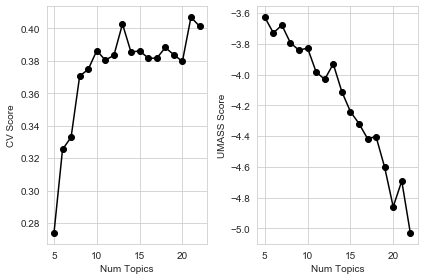

In [2]:
base_pth = './f1000_LDA_Sentence_Run_0/'
cv_arr, um_arr = LDA_Scores(base_pth)

plt.subplot(1,2,1)
plt.plot(cv_arr[:,0],cv_arr[:,1],'ko-')
plt.ylabel("CV Score")
plt.xlabel("Num Topics")

plt.subplot(1,2,2)
plt.plot(um_arr[:,0],um_arr[:,1],'ko-')
plt.ylabel("UMASS Score")
plt.xlabel("Num Topics")
plt.tight_layout()

Best model (highest CV Score) is Model_13.

Load corpus from Run_0 and Model_13.

In [3]:
num_topics = '13'
model_no = 'Model_' + num_topics
model_pth = base_pth + model_no

# Load sentence data from tsv
path_load_tsv = '../pickles/f1000_tokenized_LDA_sentence_0.tsv'
df = pd.read_csv(path_load_tsv,sep='\t',quoting=csv.QUOTE_NONE)
df.drop(columns=['Unnamed: 0'],inplace=True)
df['token'] = df['token'].str.split(',')

# Create Corpus
texts = df['token']
#Load Model
lda_model = gensim.models.ldamodel.LdaModel.load(model_pth)
id2word = gensim.corpora.Dictionary.load(model_pth + '.id2word')
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
print('Total number of sentences: %s' % len(corpus))

INFO - 13:22:28: loading LdaModel object from ./f1000_LDA_Sentence_Run_0/Model_13
INFO - 13:22:28: loading expElogbeta from ./f1000_LDA_Sentence_Run_0/Model_13.expElogbeta.npy with mmap=None
INFO - 13:22:28: setting ignored attribute dispatcher to None
INFO - 13:22:28: setting ignored attribute id2word to None
INFO - 13:22:28: setting ignored attribute state to None
INFO - 13:22:28: loaded ./f1000_LDA_Sentence_Run_0/Model_13
INFO - 13:22:28: loading LdaState object from ./f1000_LDA_Sentence_Run_0/Model_13.state
INFO - 13:22:28: loaded ./f1000_LDA_Sentence_Run_0/Model_13.state
INFO - 13:22:28: loading Dictionary object from ./f1000_LDA_Sentence_Run_0/Model_13.id2word
INFO - 13:22:28: loaded ./f1000_LDA_Sentence_Run_0/Model_13.id2word


Total number of sentences: 111931


Check model convergence.

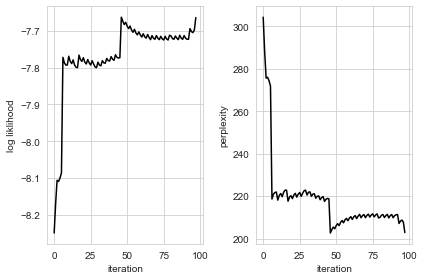

In [4]:
iter_no, perplexity, likelihood = LDA_Conv(base_pth,num_topics)
plt.subplot(1,2,1)
plt.plot(iter_no,likelihood,c="black")
plt.ylabel("log liklihood")
plt.xlabel("iteration")

plt.subplot(1,2,2)
plt.plot(iter_no,perplexity,c="black")
plt.ylabel("perplexity")
plt.xlabel("iteration")
plt.tight_layout()

Show topic visualization.

In [5]:
IPython.display.HTML(filename=model_pth+'.html')

Show topic contents (text).

In [6]:
lda_model.show_topics(num_topics=25, num_words=10, log=False, formatted=True)

[(0,
  '0.031*"present" + 0.030*"result" + 0.029*"study" + 0.021*"conclusion" + 0.020*"paper" + 0.019*"author" + 0.017*"write" + 0.017*"clear" + 0.016*"article" + 0.016*"finding"'),
 (1,
  '0.032*"reference" + 0.025*"section" + 0.023*"author" + 0.018*"mention" + 0.014*"paragraph" + 0.013*"page" + 0.013*"include" + 0.012*"introduction" + 0.011*"list" + 0.010*"reader"'),
 (2,
  '0.030*"research" + 0.015*"provide" + 0.015*"datum" + 0.013*"useful" + 0.012*"author" + 0.011*"work" + 0.010*"researcher" + 0.010*"support" + 0.008*"article" + 0.007*"science"'),
 (3,
  '0.033*"analysis" + 0.024*"use" + 0.016*"example" + 0.015*"package" + 0.012*"code" + 0.012*"author" + 0.012*"case" + 0.011*"step" + 0.011*"file" + 0.010*"tool"'),
 (4,
  '0.048*"patient" + 0.020*"treatment" + 0.018*"study" + 0.015*"case" + 0.012*"author" + 0.012*"report" + 0.011*"clinical" + 0.010*"group" + 0.008*"disease" + 0.007*"outcome"'),
 (5,
  '0.064*"figure" + 0.023*"table" + 0.022*"show" + 0.013*"value" + 0.013*"author" + 

Manually select the topics to be discarded (because they are full of technical jargon).

In [7]:
bad_topics = [4,6,7,12]

Assign topics to initial dataframe.

In [ ]:
topics = [max(lda_model.get_document_topics(row),key=itemgetter(1))[0] for row in tqdm(corpus)]

In [ ]:
df['topics'] = topics
df.head()

In [ ]:
sns.countplot(x='topics',data=df);

Filter topics.

In [ ]:
df_filter = df[~df['topics'].isin(bad_topics)].copy()
df_filter.info()

Save to tsv.

In [ ]:
path_save_tsv = "../pickles/f1000_tokenized_LDA_sentence_1.tsv"
df_filter['token'] = df_filter['token'].str.join(',')
df_filter.to_csv(path_save_tsv,sep='\t',quoting=csv.QUOTE_NONE)